In [128]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.base.datetools import dates_from_str
from sklearn.metrics import mean_squared_error

def diff(data, interval=1):
    diff = list()
    for i in range(interval, len(data)):
        value = data[i] - data[i - interval]
        diff.append(value)
    
    return diff

def plot_graph(title, data, color, name):
    fig, ax = plt.subplots(figsize=(12, 6))

    ax.plot(data, color=color)


 
    ax.grid(True, 'major', linewidth=0.34)
    spines = [ax.spines['bottom'], ax.spines['top'], ax.spines['right'], ax.spines['left']]

    for spine in spines: 
        spine.set_visible(False)

    plt.title(title, fontweight=500, fontsize=22)

    plt.savefig(name)

In [150]:
df_zillow = pd.read_csv('zillow-california.csv', index_col='Date')
df_zillow = df_zillow[~df_zillow['MedianSoldPrice_AllHomes.California'].isnull()]
df_zillow.index = dates_from_str(df_zillow.index)

In [130]:
df_zillow.shape

(95, 3)

In [131]:
df_zillow.columns

Index(['MedianSoldPrice_AllHomes.California', 'MedianMortageRate',
       'UnemploymentRate'],
      dtype='object')

In [132]:
df_zillow.tail()

,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate
2015-08-31,475000.0,3.95,5.2
2015-09-30,470000.0,3.87,5.1
2015-10-31,470000.0,3.80,5.0
2015-11-30,485750.0,3.69,5.0
2015-12-31,485000.0,3.89,5.1


In [133]:
X = df_zillow[['MedianMortageRate', 'UnemploymentRate']]
y = df_zillow[['MedianSoldPrice_AllHomes.California']]

In [134]:
X_train = X.loc[:'11-30-2014']
y_train = y.loc[:'11-30-2014']
X_valid = X.loc['12-01-2014':'11-30-2015']
y_valid = y.loc['12-01-2014':'11-30-2015']

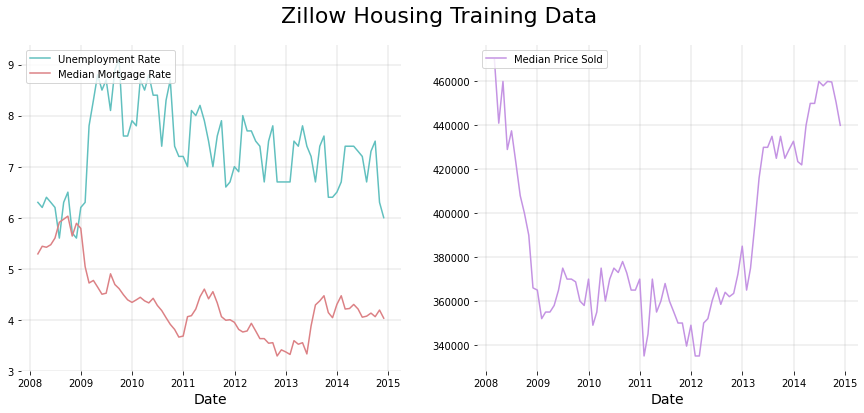

In [135]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].plot(X_train['UnemploymentRate'], label='Unemployment Rate', color='#61c0bf')
axes[0].plot(X_train['MedianMortageRate'], label="Median Mortgage Rate", color='#DC8185')
axes[1].plot(y_train, label="Median Price Sold", color='#C493E3')

for ax in axes:
    ax.grid(True, 'major', linewidth=0.34)
    ax.legend(loc='upper left')
 
    ax.set_xlabel("Date", fontweight=530, fontsize=14)
#ax.set_ylabel("Beer Drunk (Liters)", fontweight=530, fontsize=13)
    spines = [ax.spines['bottom'], ax.spines['top'], ax.spines['right'], ax.spines['left']]

    for spine in spines: 
        spine.set_visible(False)

plt.title("Zillow Housing Training Data", fontweight=500, fontsize=22, x=-0.1, y=1.05)

plt.savefig('Zillow Housing EDA')

# Unemployment Rate: 

- Somewhat quadratic? Difference twice to detrend and see what happens
- Seasonality: 1 year cycles (m=12)

In [20]:
UnempDiff1 = diff(X_train['UnemploymentRate'], 1)

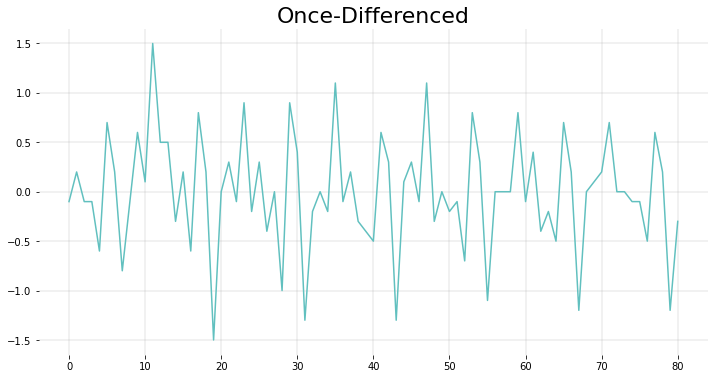

In [23]:
plot_graph("Once-Differenced", UnempDiff1, '#61c0bf', 'Unemployment-1D.png')

In [24]:
dftest = adfuller(UnempDiff1, autolag='BIC')
UnemploymentTest = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
UnemploymentTest

Test Statistic   -1.566814
p-value           0.500239
dtype: float64

In [25]:
UnempDiff2 = diff(UnempDiff1, 1)

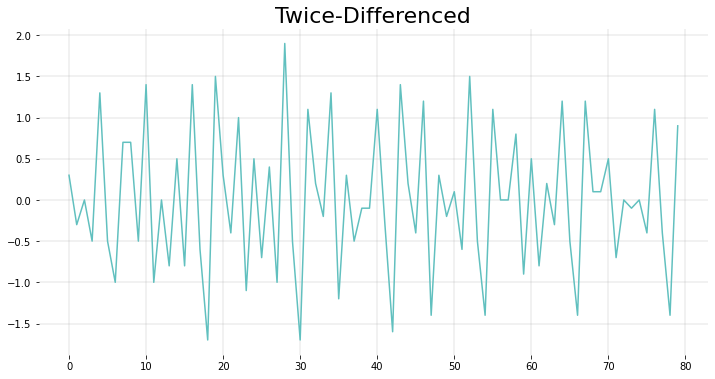

In [26]:
plot_graph("Twice-Differenced", UnempDiff2, '#61c0bf',  'Unemployment-2D.png')

In [27]:
dftest = adfuller(UnempDiff2, autolag='BIC')
UnemploymentTest = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
UnemploymentTest

Test Statistic   -1.436825e+01
p-value           9.590671e-27
dtype: float64

# Median Mortgage Rate
- Linear, difference once
- Around a two year seasonality: m=24

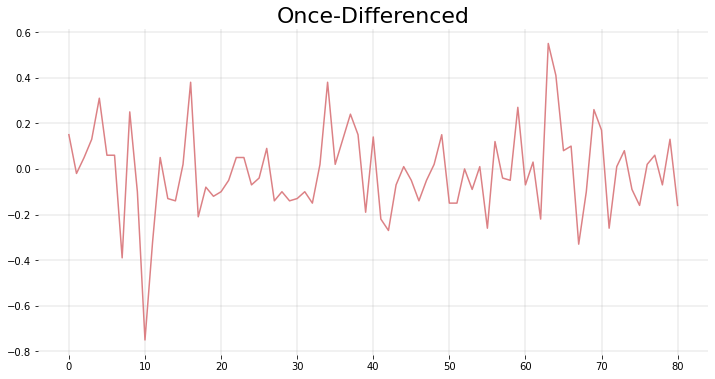

In [29]:
MortRateDiff1 = diff(X_train['MedianMortageRate'], 1)
plot_graph('Once-Differenced', MortRateDiff1, '#DC8185', 'Median-Mortgage-1D.png')

In [30]:
dftest = adfuller(MortRateDiff1, autolag='BIC')
MortRateTest = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
MortRateTest

Test Statistic   -7.895040e+00
p-value           4.333583e-12
dtype: float64

# Median Price Sold

- Also shows quadratic nature: difference twice

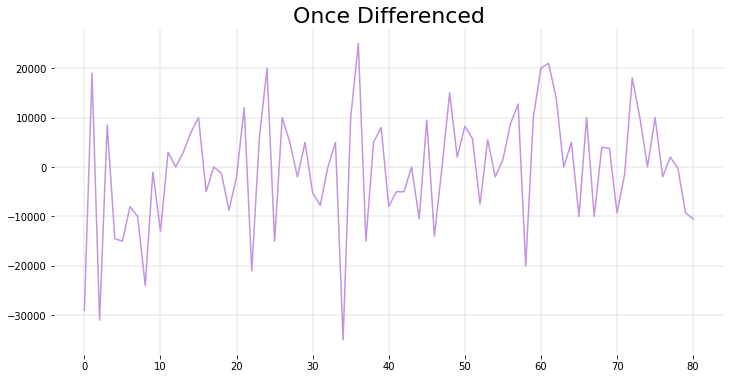

In [31]:
MedPriceDiff1 = diff(y_train['MedianSoldPrice_AllHomes.California'], 1)
plot_graph('Once Differenced', MedPriceDiff1, '#C493E3', 'Median-Price-1D.png')

In [32]:
dftest = adfuller(MedPriceDiff1, autolag='BIC')
MedPriceTest = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
MedPriceTest

Test Statistic   -1.080568e+01
p-value           1.966155e-19
dtype: float64

# EDA Conclusion:

-since Unemployment Rate needs to be twice differenced to become stationary, all other columns will follow suit

In [136]:
# MedPrice_Col2 = diff(MedPrice_Col, 1)
# MortRate_Col2 = diff(MortRate_Col, 1)
# zillow_diff = pd.DataFrame({'UnemploymentRate': Unemployment_Col,
#                             'MedianMortgageRate': MortRate_Col2,
#                             'MedianPriceSold': MedPrice_Col2
#                            })
# zillow_diff

zillow_diff = df_zillow.diff().dropna()
zillow_diff = zillow_diff.diff().dropna()
zillow_diff_train = zillow_diff.loc[:'11-30-2014']
zillow_diff_test  = zillow_diff.loc['12-1-2014':]

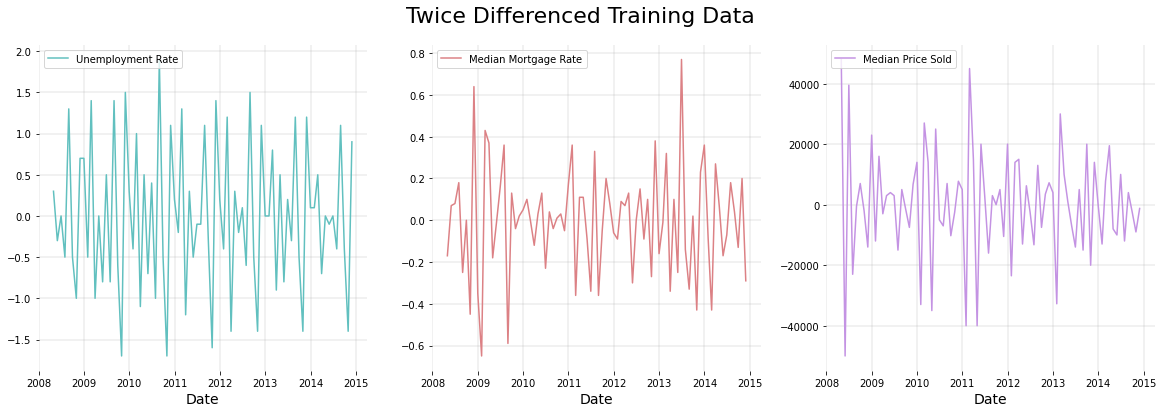

In [137]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

axes[0].plot(zillow_diff_train['UnemploymentRate'], label='Unemployment Rate', color='#61c0bf')
axes[1].plot(zillow_diff_train['MedianMortageRate'], label="Median Mortgage Rate", color='#DC8185')
axes[2].plot(zillow_diff_train['MedianSoldPrice_AllHomes.California'], label="Median Price Sold", color='#C493E3')

for ax in axes:
    ax.grid(True, 'major', linewidth=0.34)
    ax.legend(loc='upper left')
 
    ax.set_xlabel("Date", fontweight=530, fontsize=14)
#ax.set_ylabel("Beer Drunk (Liters)", fontweight=530, fontsize=13)
    spines = [ax.spines['bottom'], ax.spines['top'], ax.spines['right'], ax.spines['left']]

    for spine in spines: 
        spine.set_visible(False)

plt.title("Twice Differenced Training Data", fontweight=500, fontsize=22, x=-.75, y=1.05)

plt.savefig('Zillow-Housing-2D-EDA.png')

- Everything is now stationary
- Let's normalize so that all columns are between 0 and 1
    - Doing so because we are using a regression function which is sensitive to scale

In [138]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_input = scaler.fit_transform(zillow_diff_train)
zillow_diff_scaled = pd.DataFrame(scaled_input)
cols = zillow_diff_train.columns
zillow_diff_scaled.rename(columns = {0:cols[0], 1:cols[1], 2:cols[2]}, inplace=True)
zillow_diff_scaled.head()

,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate
0,1.000000,0.338028,0.555556
1,0.000000,0.507042,0.388889
2,0.913265,0.514085,0.472222
3,0.275510,0.584507,0.333333
4,0.505102,0.281690,0.833333


In [139]:
df_zillow = df_zillow.rename(columns={"MedianSoldPrice_AllHomes.California":"MedianPriceSold",
                                      "MedianMortageRate":"MedianMortgageRate"
})
zillow_diff_scaled = zillow_diff_scaled.rename(columns={"MedianSoldPrice_AllHomes.California":"MedianPriceSold",
                                      "MedianMortageRate":"MedianMortgageRate"
})

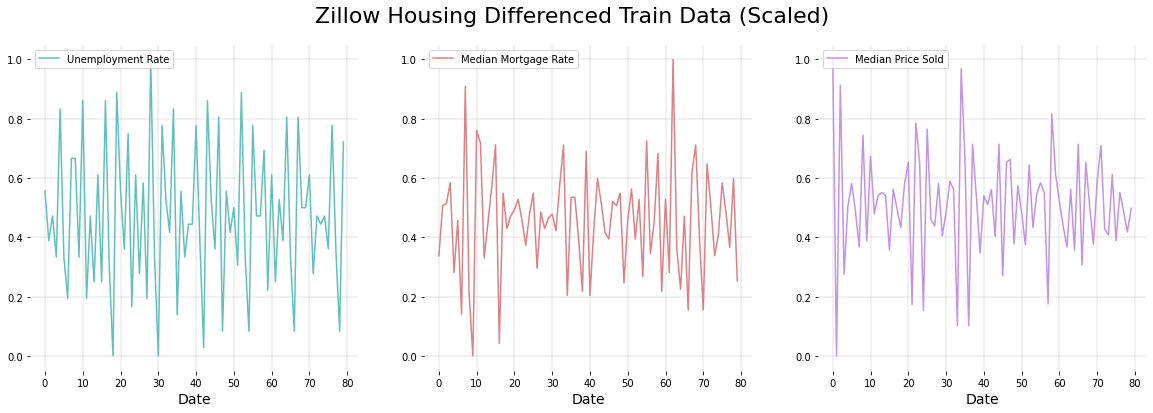

In [140]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

axes[0].plot(zillow_diff_scaled['UnemploymentRate'], label='Unemployment Rate', color='#61c0bf')
axes[1].plot(zillow_diff_scaled['MedianMortgageRate'], label="Median Mortgage Rate", color='#DC8185')
axes[2].plot(zillow_diff_scaled['MedianPriceSold'], label="Median Price Sold", color='#C493E3')

for ax in axes:
    ax.grid(True, 'major', linewidth=0.34)
    ax.legend(loc='upper left')
 
    ax.set_xlabel("Date", fontweight=530, fontsize=14)
#ax.set_ylabel("Beer Drunk (Liters)", fontweight=530, fontsize=13)
    spines = [ax.spines['bottom'], ax.spines['top'], ax.spines['right'], ax.spines['left']]

    for spine in spines: 
        spine.set_visible(False)

plt.title("Zillow Housing Differenced Train Data (Scaled)", fontweight=500, fontsize=22, x=-.75, y=1.05)

plt.show()

In [141]:
model = VAR(zillow_diff_scaled)
results = model.fit(maxlags=15, ic='bic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 08, Mar, 2021
Time:                     16:04:44
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -10.6017
Nobs:                     75.0000    HQIC:                  -11.4927
Log likelihood:           181.922    FPE:                5.75806e-06
AIC:                     -12.0849    Det(Omega_mle):     3.22356e-06
--------------------------------------------------------------------
Results for equation MedianPriceSold
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                         0.808931         0.266405            3.036           0.002
L1.MedianPriceSold           -0.807157         0.135795           -5.944           0.000
L1.MedianMortgageR

# Forecast Analysis

- Now that we have our forecast, we will:
    1. Unscale all columns
    2. Undifference all columns

In [44]:
#test = pd.read_csv('test.csv', index_col='Month')
test.index = dates_from_str(test.index)

In [53]:
X_valid

,MedianMortageRate,UnemploymentRate
2014-12-31,3.90,6.2
2015-01-31,3.85,6.2
2015-02-28,3.89,5.7
2015-03-31,3.91,5.5
2015-04-30,3.79,5.4
2015-05-31,3.73,5.4
2015-06-30,3.85,5.6
2015-07-31,3.87,5.3
2015-08-31,3.95,5.2
2015-09-30,3.87,5.1


In [142]:
# Twelve months in the forecast
period = 12
pred = results.forecast(results.y, steps=period)
zillow_forecast_scaled = pd.DataFrame(pred, index=X_valid.index, columns= df_zillow.columns+'_1d')
zillow_forecast_scaled.head()

/Users/okeefe/.pyenv/versions/3.8.1/lib/python3.8/site-packages/statsmodels/base/wrapper.py:34: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


,MedianPriceSold_1d,MedianMortgageRate_1d,UnemploymentRate_1d
2014-12-31,0.615300,0.529476,0.537829
2015-01-31,0.295180,0.421954,0.390104
2015-02-28,0.590213,0.421419,0.705695
2015-03-31,0.719544,0.416306,0.304277
2015-04-30,0.297770,0.534787,0.353971


In [143]:
zillow_forecast = scaler.inverse_transform(np.array(zillow_forecast_scaled))
zillow_forecast = pd.DataFrame(zillow_forecast, index=X_valid.index, columns=df_zillow.columns+'_1d')
zillow_forecast

,MedianPriceSold_1d,MedianMortgageRate_1d,UnemploymentRate_1d
2014-12-31,10299.431479,0.101856,0.236184
2015-01-31,-21072.361310,-0.050825,-0.295625
2015-02-28,7840.878552,-0.051585,0.840502
2015-03-31,20515.332881,-0.058846,-0.604602
2015-04-30,-20818.558694,0.109397,-0.425706
2015-05-31,7233.077854,0.035058,0.621900
2015-06-30,3693.705676,-0.081630,-0.214750
2015-07-31,-11837.733872,0.087930,-0.315186
2015-08-31,7341.092442,-0.057731,0.488459
2015-09-30,4963.445753,-0.076815,-0.067186


In [144]:
def invert_transformation(train, dt_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    dt_fc = dt_forecast.copy()
    columns = train.columns
    print(dt_fc)
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            dt_fc[str(col)+'_1d'] = (train[col].iloc[-1]-train[col].iloc[-2]) + dt_fc[str(col)+'_1d'].cumsum()
        # Roll back 1st Diff
        dt_fc[str(col)+'_forecast'] = train[col].iloc[-1] + dt_fc[str(col)+'_1d'].cumsum()
    return dt_fc

In [145]:
dt_results = invert_transformation(df_zillow, zillow_forecast, second_diff=True)
dt_results

            MedianPriceSold_1d  MedianMortgageRate_1d  UnemploymentRate_1d
2014-12-31        10299.431479               0.101856             0.236184
2015-01-31       -21072.361310              -0.050825            -0.295625
2015-02-28         7840.878552              -0.051585             0.840502
2015-03-31        20515.332881              -0.058846            -0.604602
2015-04-30       -20818.558694               0.109397            -0.425706
2015-05-31         7233.077854               0.035058             0.621900
2015-06-30         3693.705676              -0.081630            -0.214750
2015-07-31       -11837.733872               0.087930            -0.315186
2015-08-31         7341.092442              -0.057731             0.488459
2015-09-30         4963.445753              -0.076815            -0.067186
2015-10-31        -9741.088637               0.083829            -0.347941
2015-11-30         4195.812694              -0.019158             0.392321


,MedianPriceSold_1d,MedianMortgageRate_1d,UnemploymentRate_1d,MedianPriceSold_forecast,MedianMortgageRate_forecast,UnemploymentRate_forecast
2014-12-31,9549.431479,0.301856,0.336184,494549.431479,4.191856,5.436184
2015-01-31,-11522.929831,0.251031,0.040558,483026.501647,4.442886,5.476742
2015-02-28,-3682.051280,0.199446,0.881060,479344.450368,4.642333,6.357802
2015-03-31,16833.281601,0.140600,0.276458,496177.731969,4.782933,6.634260
2015-04-30,-3985.277093,0.249997,-0.149248,492192.454875,5.032931,6.485013
2015-05-31,3247.800761,0.285056,0.472653,495440.255637,5.317986,6.957665
2015-06-30,6941.506437,0.203426,0.257903,502381.762074,5.521412,7.215568
2015-07-31,-4896.227434,0.291356,-0.057284,497485.534639,5.812768,7.158284
2015-08-31,2444.865008,0.233625,0.431175,499930.399647,6.046392,7.589459
2015-09-30,7408.310761,0.156809,0.363990,507338.710409,6.203202,7.953449


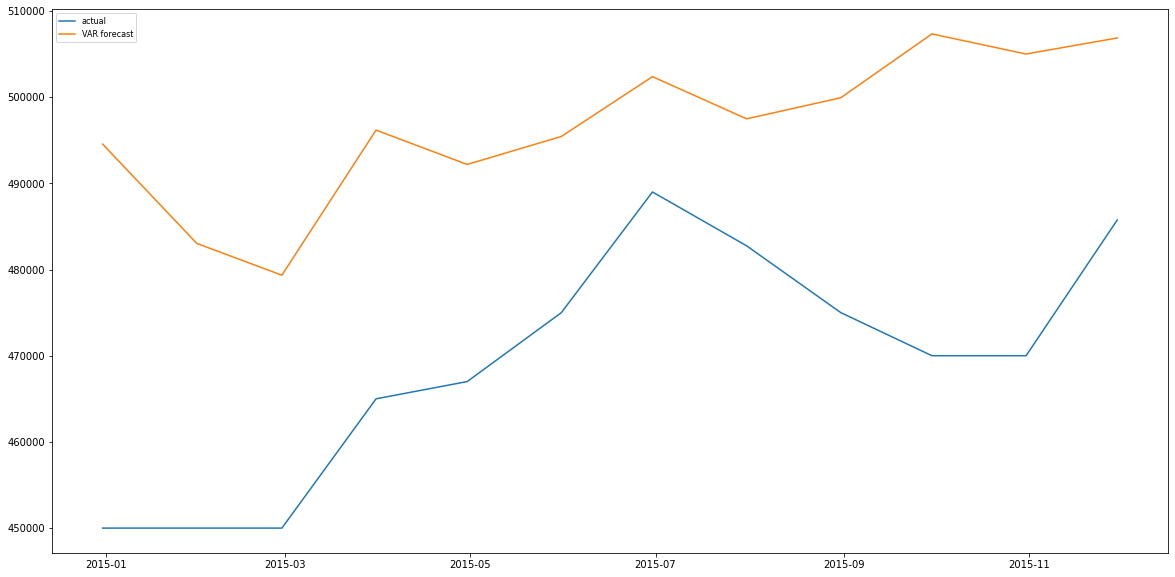

In [146]:
plt.figure(figsize=(20,10))
plt.plot(y_valid['MedianSoldPrice_AllHomes.California'], label="actual")
plt.plot(dt_results.MedianPriceSold_forecast, label='VAR forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

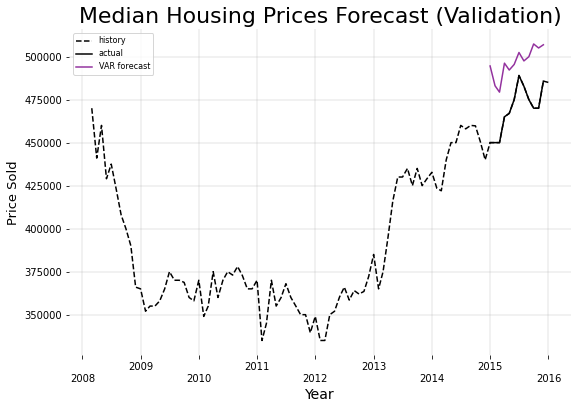

In [153]:
fig, ax = plt.subplots(figsize=(9,6))
#pred.index = actual.index
ax.plot(y, label="history", color='black', linestyle='--')
ax.plot(y_valid['MedianSoldPrice_AllHomes.California'], label='actual', color='black')
ax.plot(dt_results.MedianPriceSold_forecast, label='VAR forecast', color='#93329e')

ax.legend(loc='upper left', fontsize=8)
for tick in ax.xaxis.get_major_ticks()[1::2]:
    tick.set_pad(15)
ax.set_xlabel("Year", fontweight=530, fontsize=14)
ax.set_ylabel("Price Sold", fontweight=530, fontsize=13)
plt.title("Median Housing Prices Forecast (Validation)", fontweight=500, fontsize=22)
spines = [ax.spines['bottom'], ax.spines['top'], ax.spines['right'], ax.spines['left']]

for spine in spines: 
    spine.set_visible(False)
plt.grid(True, 'major', linewidth=0.34)
#plt.show()
plt.savefig('VAR-Forecast-Valid.png')

In [83]:
rms_VAR = mean_squared_error(y_valid['MedianSoldPrice_AllHomes.California'], dt_results.MedianPriceSold_forecast, squared=False)
rms_VAR

28931.457764717685

# Candidate #1:
    - VAR (Twice differenced and scaled)
    - RMSE = 28931.7

# SARIMAX
- Exogenous Relationship between inputs (MedianMortgageRate, UnemploymentRate) and output (MedianPriceSold)
    - Meaning that history informs the present, but the present inputs don't impact the present output

In [99]:
# Upload data and split into train and test
df_zillow = pd.read_csv('zillow-california.csv', index_col='Date')
test_y = pd.read_csv('test.csv')
cols = ['MedianPriceSold', 'MedianMortgageRate', 'UnemploymentRate']
df_zillow = df_zillow.rename(columns={'MedianSoldPrice_AllHomes.California':cols[0], 'MedianMortageRate':cols[1]})

train = df_zillow[~df_zillow['MedianPriceSold'].isnull()].copy()

test = df_zillow[df_zillow['MedianPriceSold'].isnull()].copy()
test['MedianPriceSold'] = test_y['Median House Price'].array

train.index = dates_from_str(train.index)
test.index = dates_from_str(test.index)

In [100]:
valid = train.loc['12-01-2014':'11-30-2015']
train = train.loc[:'11-30-2014']

In [104]:
# Scale Train and Test
scaler = MinMaxScaler(feature_range=(0, 1))

train_scaled = scaler.fit_transform(train)
train_scaled =pd.DataFrame(train_scaled)
cols = ['MedianPriceSold', 'MedianMortgageRate', 'UnemploymentRate']
train_scaled.rename(columns={0:cols[0], 1:cols[1], 2:cols[2]}, inplace=True)
train_scaled.index = train.index

valid_scaled = scaler.fit_transform(valid)
valid_scaled = pd.DataFrame(valid_scaled)
valid_scaled.rename(columns={0:cols[0], 1:cols[1], 2:cols[2]}, inplace=True)
valid_scaled.index = valid.index

In [105]:
#SARIMAX order selection
from pmdarima.arima import auto_arima
model=auto_arima(train_scaled['MedianPriceSold'], 
                     exogenous= train_scaled[['MedianMortgageRate', 'UnemploymentRate']],
                     start_p=1, start_q=1, 
                     max_p=7, max_q=7, 
                     d=1, max_d=3,
                     trace=True, seasonal=True,D=1,m=24, max_P=3, max_Q=3,
                     error_action='ignore', 
                     suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[24]             : AIC=-98.577, Time=1.55 sec
 ARIMA(0,1,0)(0,1,0)[24]             : AIC=-92.461, Time=0.13 sec
 ARIMA(1,1,0)(1,1,0)[24]             : AIC=-100.006, Time=0.63 sec
 ARIMA(0,1,1)(0,1,1)[24]             : AIC=-97.984, Time=0.86 sec
 ARIMA(1,1,0)(0,1,0)[24]             : AIC=-99.107, Time=0.12 sec
 ARIMA(1,1,0)(2,1,0)[24]             : AIC=-98.881, Time=3.69 sec
 ARIMA(1,1,0)(1,1,1)[24]             : AIC=-98.880, Time=1.29 sec
 ARIMA(1,1,0)(0,1,1)[24]             : AIC=-100.840, Time=0.59 sec
 ARIMA(1,1,0)(0,1,2)[24]             : AIC=-98.881, Time=2.42 sec
 ARIMA(1,1,0)(1,1,2)[24]             : AIC=-96.881, Time=3.31 sec
 ARIMA(0,1,0)(0,1,1)[24]             : AIC=-97.006, Time=0.62 sec
 ARIMA(2,1,0)(0,1,1)[24]             : AIC=-105.170, Time=1.07 sec
 ARIMA(2,1,0)(0,1,0)[24]             : AIC=-101.617, Time=0.23 sec
 ARIMA(2,1,0)(1,1,1)[24]             : AIC=inf, Time=1.60 sec
 ARIMA(2,1,0)(0,1,2)[24]         

In [107]:
y_pred = model.predict(n_periods=len(valid_scaled),X=valid_scaled[['MedianMortgageRate', 'UnemploymentRate']]).reshape(-1, 1)
y_pred_ = np.repeat(y_pred,3,axis=1) # duplicate the pred column x3 times to fit the scaler's shape
y_pred_inv = scaler.inverse_transform(y_pred_) # inverset he duplicated y_pred and get the last colomn as result
y_pred = y_pred_inv[:, 0]

In [109]:
y_valid = valid['MedianPriceSold']
y_pred = pd.DataFrame(y_pred)
y_pred.rename(columns={0:'MedianPriceSold'}, inplace=True)
y_pred.set_index(y_valid.index, inplace=True)

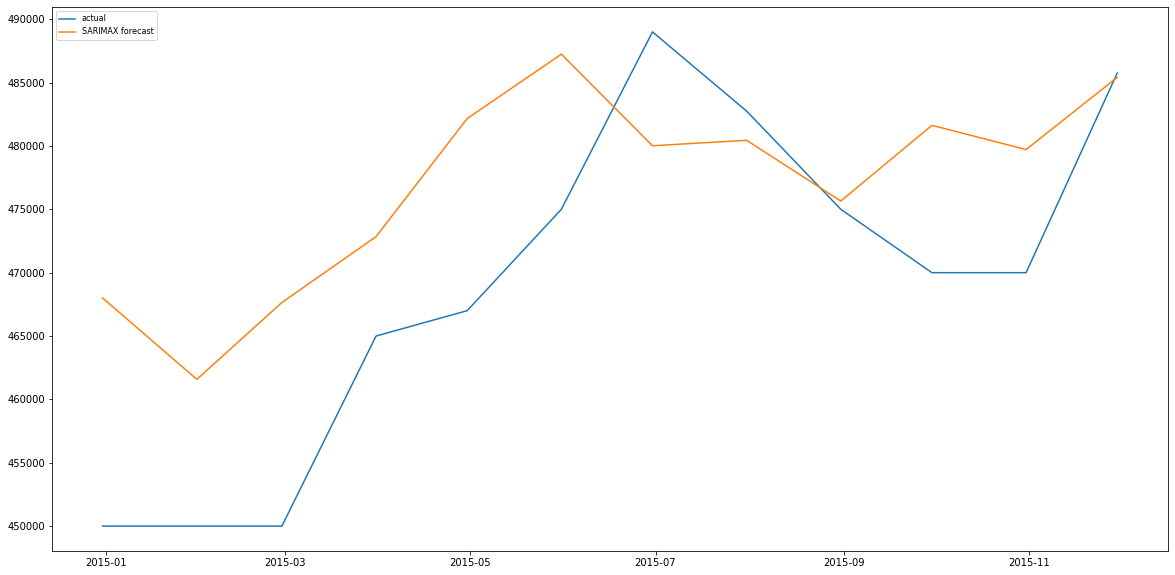

In [111]:
plt.figure(figsize=(20,10))
plt.plot(y_valid, label="actual")
plt.plot(y_pred, label='SARIMAX forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

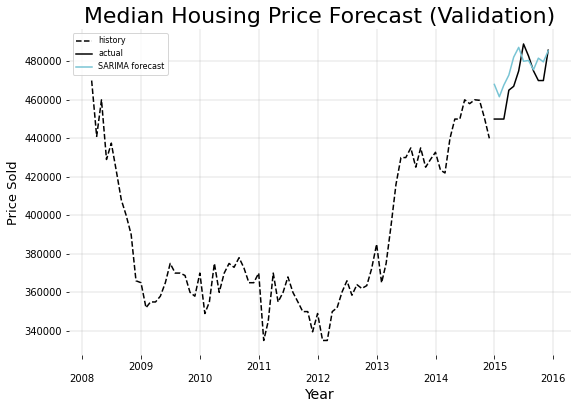

In [154]:
fig, ax = plt.subplots(figsize=(9,6))
# train.index = dates_from_str(train.index)
# y_test.index = dates_from_str(y_test.index)
# y_pred.index = dates_from_str(y_pred.index)
ax.plot(train['MedianPriceSold'], label="history", color='black', linestyle='--')
ax.plot(y_valid, label='actual', color='black')
ax.plot(y_pred, label='SARIMA forecast', color='#78c4d4')

ax.legend(loc='upper left', fontsize=8)
for tick in ax.xaxis.get_major_ticks()[1::2]:
    tick.set_pad(15)
ax.set_xlabel("Year", fontweight=530, fontsize=14)
ax.set_ylabel("Price Sold", fontweight=530, fontsize=13)
plt.title("Median Housing Price Forecast (Validation)", fontweight=500, fontsize=22)
spines = [ax.spines['bottom'], ax.spines['top'], ax.spines['right'], ax.spines['left']]

for spine in spines: 
    spine.set_visible(False)
plt.grid(True, 'major', linewidth=0.34)
plt.savefig('SARIMAX-Forecast-Valid.png')

In [115]:
rms_SARIMA = mean_squared_error(y_valid, y_pred, squared=False)
rms_SARIMA

11279.886258498022

# Candidate 2:
 - SARIMAX(3, 1, 0)(0, 1, 1, 24)
 - MSE = 11279.886

# Summary:
- Of the two candidates I explored, VAR was the most accurate with a forecast MSE of 22956 (as opposed to SARIMAX's 29330)

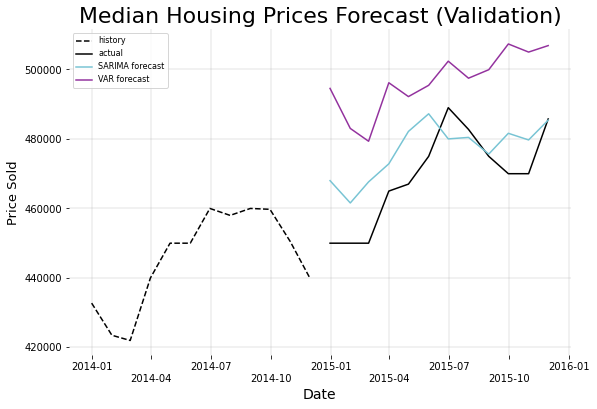

In [119]:
fig, ax = plt.subplots(figsize=(9,6))
#pred.index = actual.index
ax.plot(train['MedianPriceSold'][-12:], label="history", color='black', linestyle='--')
ax.plot(y_valid, label='actual', color='black')
ax.plot(y_pred, label='SARIMA forecast', color='#78c4d4')
ax.plot(dt_results.MedianPriceSold_forecast, label='VAR forecast', color='#93329e')

ax.legend(loc='upper left', fontsize=8)
for tick in ax.xaxis.get_major_ticks()[1::2]:
    tick.set_pad(15)
ax.set_xlabel("Date", fontweight=530, fontsize=14)
ax.set_ylabel("Price Sold", fontweight=530, fontsize=13)
plt.title("Median Housing Prices Forecast (Validation)", fontweight=500, fontsize=22)
spines = [ax.spines['bottom'], ax.spines['top'], ax.spines['right'], ax.spines['left']]

for spine in spines: 
    spine.set_visible(False)
plt.grid(True, 'major', linewidth=0.34)
plt.savefig('Median_Housing_Prices_Validation')

In [126]:
np.array(y_pred).squeeze()

array([467998.30827513, 461579.5843142 , 467644.31873109, 472845.36062689,
       482161.87265864, 487242.6672456 , 480015.32794727, 480447.32752515,
       475651.98022378, 481628.16862087, 479715.39471704, 485414.92817339])

In [125]:
np.array(dt_results.MedianPriceSold_forecast)

array([494549.43147862, 483026.50164715, 479344.45036753, 496177.73196852,
       492192.45487531, 495440.25563654, 502381.76207361, 497485.53463917,
       499930.39964714, 507338.7104085 , 505005.93253324, 506868.96735219])

In [127]:
y_pred.index

DatetimeIndex(['2014-12-31', '2015-01-31', '2015-02-28', '2015-03-31',
               '2015-04-30', '2015-05-31', '2015-06-30', '2015-07-31',
               '2015-08-31', '2015-09-30', '2015-10-31', '2015-11-30'],
              dtype='datetime64[ns]', freq=None)